<a href="https://colab.research.google.com/github/denpetrov/01_04_sequences-time-series-and-prediction/blob/master/w04_S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 319kB/s 
     |████████████████████████████████| 3.1MB 48.9MB/s 
     |████████████████████████████████| 501kB 56.0MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-09-11 20:33:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2019-09-11 20:33:56 (54.9 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



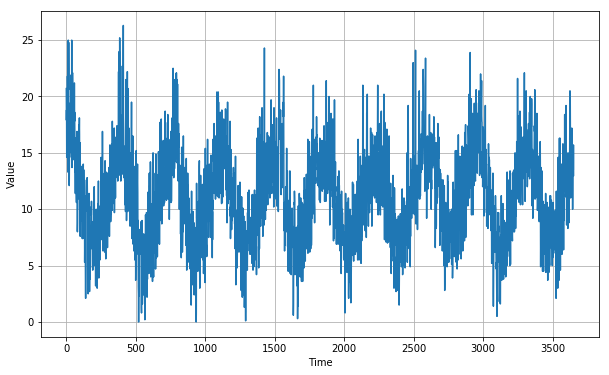

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i, row in enumerate(reader, 1):
    temps.append(float(row[1]))
    time_step.append(i)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]  # YOUR CODE HERE
x_train = series[:split_time]  # YOUR CODE HERE
time_valid = time[split_time:]  # YOUR CODE HERE
x_valid = series[split_time:]  # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # YOUR CODE HERE
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
  # YOUR CODE HERE
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 27)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 6s 604ms/step - loss: 11.7406 - mae: 12.2442
Epoch 2/100
10/10 [==============================] - 4s 374ms/step - loss: 11.7382 - mae: 12.2414
Epoch 3/100
10/10 [==============================] - 4s 371ms/step - loss: 11.7340 - mae: 12.2373
Epoch 4/100
10/10 [==============================] - 4s 380ms/step - loss: 11.7289 - mae: 12.2322
Epoch 5/100
10/10 [==============================] - 4s 379ms/step - loss: 11.7231 - mae: 12.2263
Epoch 6/100
10/10 [==============================] - 4s 385ms/step - loss: 11.7164 - mae: 12.2197
Epoch 7/100
10/10 [==============================] - 4s 383ms/step - loss: 11.7090 - mae: 12.2122
Epoch 8/100
10/10 [==============================] - 4s 379ms/step - loss: 11.7005 - mae: 12.2038
Epoch 9/100
10/10 [=

[1e-08, 0.0001, 0, 60]

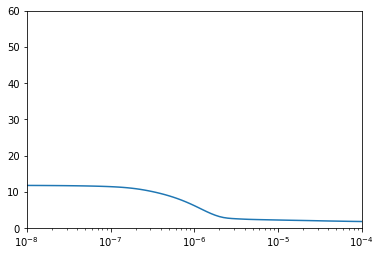

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

[1e-08, 0.0001, 0, 60]

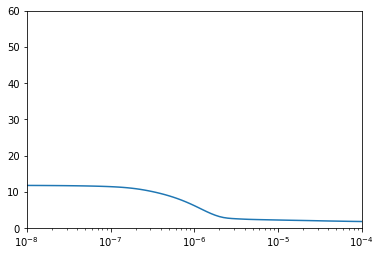

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 27)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)  # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)  # YOUR CODE HERE
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 7s 268ms/step - loss: 7.9254 - mae: 8.5386
Epoch 2/500
25/25 [==============================] - 5s 183ms/step - loss: 2.6296 - mae: 3.0983
Epoch 3/500
25/25 [==============================] - 5s 183ms/step - loss: 2.3075 - mae: 2.7667
Epoch 4/500
25/25 [==============================] - 5s 184ms/step - loss: 2.2060 - mae: 2.6618
Epoch 5/500
25/25 [==============================] - 5s 183ms/step - loss: 2.1518 - mae: 2.6074
Epoch 6/500
25/25 [==============================] - 5s 183ms/step - loss: 2.1123 - mae: 2.5675
Epoch 7/500
25/25 [==============================] - 5s 184ms/step - loss: 2.0779 - mae: 2.5334
Epoch 8/500
25/25 [==============================] - 5s 183ms/step - loss: 2.0472 - mae: 2.5027
Epoch 9/500
25/25 [==============================] - 5s 184ms/step - loss: 2.0179 - mae: 2.4732
Epoch 10/500
25/25 [==============================] - 5s 183ms/step - loss: 1.9923 - mae: 2.4472
Epoch 11/500
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

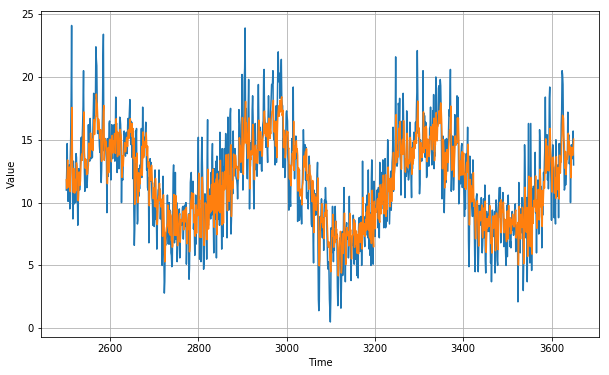

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.784548

In [16]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS
# [11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]

[11.816039 11.13395  12.275345 ... 13.746062 13.845907 15.052855]
